In [1]:
import numpy as np
import gzip
import ROOT
import array
import math

# File paths
lhe_file = "/Users/johno.aremu/Documents/pp2zz2llvv/unweighted_events.lhe.gz"
root_file_path = "pp_to_llvv.root"

# Prepare ROOT file and tree
root_file = ROOT.TFile(root_file_path, "RECREATE")
tree = ROOT.TTree("Events", "pp --> ZZ --> llvv events")

# Branch variables
run = array.array('i', [1])
luminosityBlock = array.array('I', [1])
event_number = array.array('L', [0])

# Muon variables
nMuon = array.array('I', [0])
Muon_pt = ROOT.std.vector('float')()
Muon_eta = ROOT.std.vector('float')()
Muon_phi = ROOT.std.vector('float')()
Muon_mass = ROOT.std.vector('float')()
Muon_charge = ROOT.std.vector('int')()

# Electron variables
nElectron = array.array('I', [0])
Electron_pt = ROOT.std.vector('float')()
Electron_eta = ROOT.std.vector('float')()
Electron_phi = ROOT.std.vector('float')()
Electron_mass = ROOT.std.vector('float')()
Electron_charge = ROOT.std.vector('int')()

#Neutrino variables
nNeutrino = array.array('I', [0])
Neutrino_pt = ROOT.std.vector('float')()
Neutrino_eta = ROOT.std.vector('float')()
Neutrino_phi = ROOT.std.vector('float')()
Neutrino_mass = ROOT.std.vector('float')()

# MET variables
MET_pt = array.array('f', [0.])
MET_phi = array.array('f', [0.])

# Create branches
tree.Branch("run", run, "run/I") 
tree.Branch("luminosityBlock", luminosityBlock, "luminosityBlock/i")
tree.Branch("event", event_number, "event/l")

tree.Branch("nMuon", nMuon, "nMuon/i")
tree.Branch("Muon_pt", Muon_pt)
tree.Branch("Muon_eta", Muon_eta)
tree.Branch("Muon_phi", Muon_phi)
tree.Branch("Muon_mass", Muon_mass)
tree.Branch("Muon_charge", Muon_charge)

tree.Branch("nElectron", nElectron, "nElectron/i")
tree.Branch("Electron_pt", Electron_pt)
tree.Branch("Electron_eta", Electron_eta)
tree.Branch("Electron_phi", Electron_phi)
tree.Branch("Electron_mass", Electron_mass)
tree.Branch("Electron_charge", Electron_charge)

tree.Branch("nNeutrino", nNeutrino, "nNeutrino/i")
tree.Branch("Neutrino_pt", Neutrino_pt)
tree.Branch("Neutrino_eta", Neutrino_eta)
tree.Branch("Neutrino_phi", Neutrino_phi)
tree.Branch("Neutrino_mass", Neutrino_mass)

tree.Branch("MET_pt", MET_pt, "MET_pt/F")
tree.Branch("MET_phi", MET_phi, "MET_phi/F")

# Utility functions
def compute_pt(px, py):
    return np.sqrt(px**2 + py**2)

def compute_eta(px, py, pz):
    p = np.sqrt(px**2 + py**2 + pz**2)
    if p == abs(pz):
        return 0.0  # avoid divide by zero or inf
    return 0.5 * np.log((p + pz) / (p - pz))

def compute_phi(px, py):
    return np.arctan2(py, px)

# Read and parse LHE file
with gzip.open(lhe_file, 'rt') as f:
    in_event = False
    event_lines = []
    event_id = 0

    for line in f:
        line = line.strip()

        if line == "<event>":
            in_event = True
            event_lines = []
        elif line == "</event>":
            in_event = False
            event_id += 1
            event_number[0] = event_id

            # Reset all vectors
            Muon_pt.clear()
            Muon_eta.clear()
            Muon_phi.clear()
            Muon_mass.clear()
            Muon_charge.clear()
            Electron_pt.clear()
            Electron_eta.clear()
            Electron_phi.clear()
            Electron_mass.clear()
            Electron_charge.clear()
            Neutrino_pt.clear()
            Neutrino_eta.clear()
            Neutrino_phi.clear()
            Neutrino_mass.clear()

            # MET variables
            met_px = 0.0
            met_py = 0.0

            # Parse event lines
            particles = event_lines[1:]  # skip header line
            for p in particles:
                tokens = p.strip().split()
                if len(tokens) < 10:
                    continue

                pdg_id = int(tokens[0])
                status = int(tokens[1])
                mother1 = int(tokens[2])
                mother2 = int(tokens[3])
                color1 = int(tokens[4])
                color2 = int(tokens[5])
                px = float(tokens[6])
                py = float(tokens[7])
                pz = float(tokens[8])
                E  = float(tokens[9])
                mass = float(tokens[10])
                charge = 0

                # Determine charge
                if pdg_id in [11, 13]: charge = -1
                elif pdg_id in [-11, -13]: charge = 1

                pt = compute_pt(px, py)
                phi = compute_phi(px, py)
                eta = compute_eta(px, py, pz)

                if abs(pdg_id) == 11:  # Electrons
                    Electron_pt.push_back(pt)
                    Electron_eta.push_back(eta)
                    Electron_phi.push_back(phi)
                    Electron_mass.push_back(mass)
                    Electron_charge.push_back(charge)

                elif abs(pdg_id) == 13:  # Muons
                    Muon_pt.push_back(pt)
                    Muon_eta.push_back(eta)
                    Muon_phi.push_back(phi)
                    Muon_mass.push_back(mass)
                    Muon_charge.push_back(charge)

                elif abs(pdg_id) in [12, 14, 16]:  # Neutrinos
                    Neutrino_pt.push_back(pt)
                    Neutrino_eta.push_back(eta)
                    Neutrino_phi.push_back(phi)
                    Neutrino_mass.push_back(mass)
                    # Neutrinos are neutral, no charge


                    # Update MET
                    met_px += px
                    met_py += py

            # Finalize counts
            nMuon[0] = Muon_pt.size()
            nElectron[0] = Electron_pt.size()
            nNeutrino[0] = Neutrino_pt.size()

            # MET
            MET_pt[0] = np.sqrt(met_px**2 + met_py**2)
            MET_phi[0] = np.arctan2(met_py, met_px)

            # Fill tree
            tree.Fill()

        elif in_event:
            event_lines.append(line)

# Write and close
root_file.Write()
root_file.Close()

print(f"Finished writing ROOT file: {root_file_path}")
print(f"Total events processed: {event_id}")


Finished writing ROOT file: pp_to_llvv.root
Total events processed: 10000


In [2]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import hist
import vector

vector.register_awkward()

file = uproot.open("pp_to_llvv.root")
tree = file["Events"]

#check the branches in the tree
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run                  | int32_t                  | AsDtype('>i4')
luminosityBlock      | uint32_t                 | AsDtype('>u4')
event                | uint64_t                 | AsDtype('>u8')
nMuon                | uint32_t                 | AsDtype('>u4')
Muon_pt              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
Muon_eta             | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
Muon_phi             | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
Muon_mass            | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
Muon_charge          | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
nElectron            | uint32_t                 | AsDtype('>u4')
Electron_pt          | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
Electron_eta         | std:

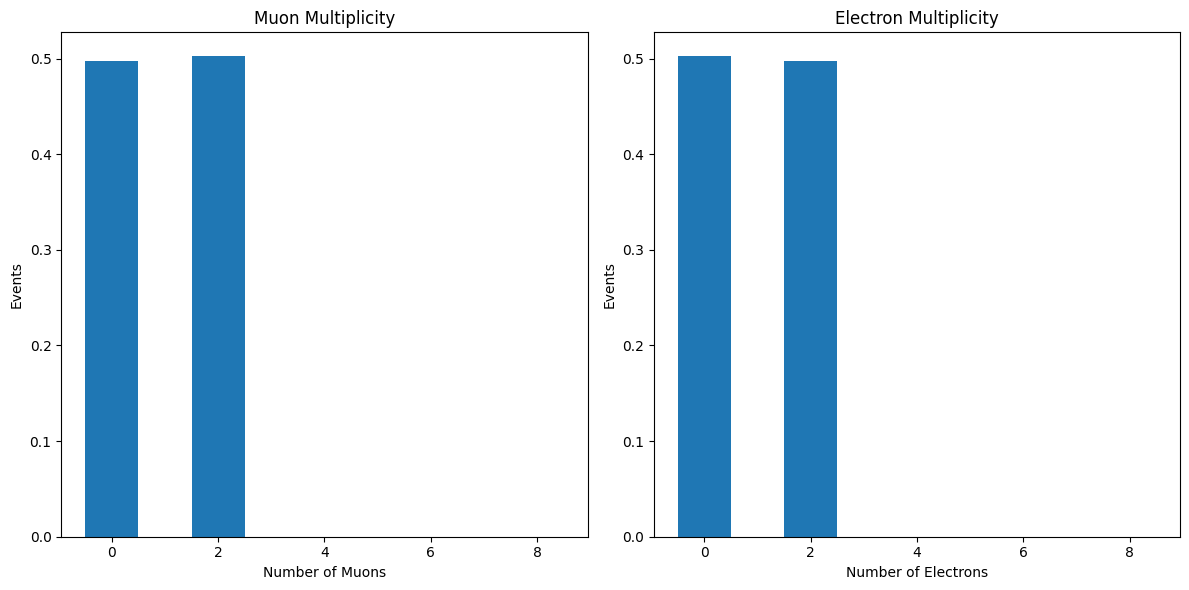

In [3]:
mu_events = tree.arrays(["Muon_pt", "Muon_eta", "Muon_phi", "Muon_mass", "Muon_charge"])
elec_events = tree.arrays(["Electron_pt", "Electron_eta", "Electron_phi", "Electron_mass", "Electron_charge"])

muons = ak.zip({    
"pt": mu_events.Muon_pt,    
"eta": mu_events.Muon_eta,    
"phi": mu_events.Muon_phi,    
"mass": mu_events.Muon_mass,       
"charge": mu_events.Muon_charge
}, with_name="Momentum4D")

electrons = ak.zip({    
"pt": elec_events.Electron_pt,    
"eta": elec_events.Electron_eta,    
"phi": elec_events.Electron_phi,    
"mass": elec_events.Electron_mass,    
"charge": elec_events.Electron_charge
}, with_name="Momentum4D")

#sanity check: plot nElectron and nMuon distributions using hist
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Muon Multiplicity")
plt.xlabel("Number of Muons")
plt.ylabel("Events")
plt.hist(ak.num(muons), bins=np.arange(0, 10)-0.5, density=True)

plt.subplot(1, 2, 2)
plt.title("Electron Multiplicity")
plt.xlabel("Number of Electrons")
plt.ylabel("Events")
plt.hist(ak.num(electrons), bins=np.arange(0, 10)-0.5, density=True)

plt.tight_layout()
plt.show()

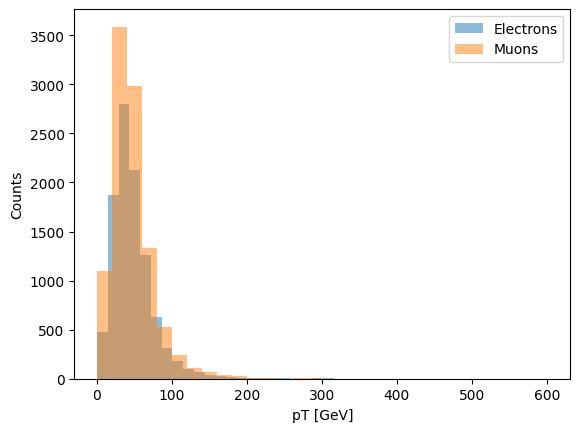

In [4]:
# Plot pT distributions for electrons and muons
electron_pts = ak.flatten(elec_events.Electron_pt)
muon_pts = ak.flatten(mu_events.Muon_pt)

plt.hist(electron_pts, bins=30, alpha=0.5, label="Electrons")
plt.hist(muon_pts, bins=30, alpha=0.5, label="Muons")
plt.xlabel("pT [GeV]")
plt.ylabel("Counts")
plt.legend()
plt.show()

/opt/anaconda3/envs/my_cern/lib/python3.13/site-packages/mplhep/utils.py:741: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/opt/anaconda3/envs/my_cern/lib/python3.13/site-packages/mplhep/utils.py:741: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/opt/anaconda3/envs/my_cern/lib/python3.13/site-packages/mplhep/utils.py:741: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.
  self.errors()
/opt/anaconda3/envs/my_cern/lib/python3.13/site-packages/mplhep/utils.py:741: UserWarning: Integer weights indicate poissonian data. Will calculate Garwood interval if ``scipy`` is installed. Otherwise errors will be set to ``sqrt(w2)``.


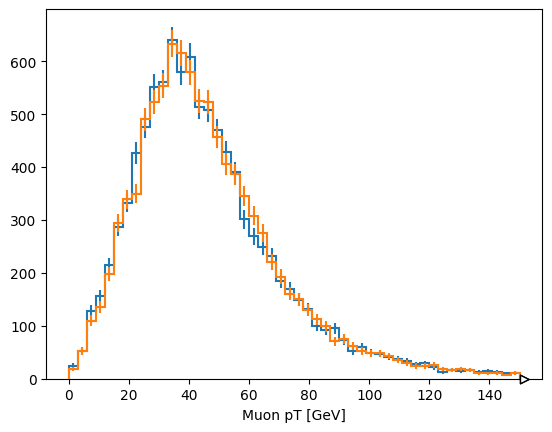

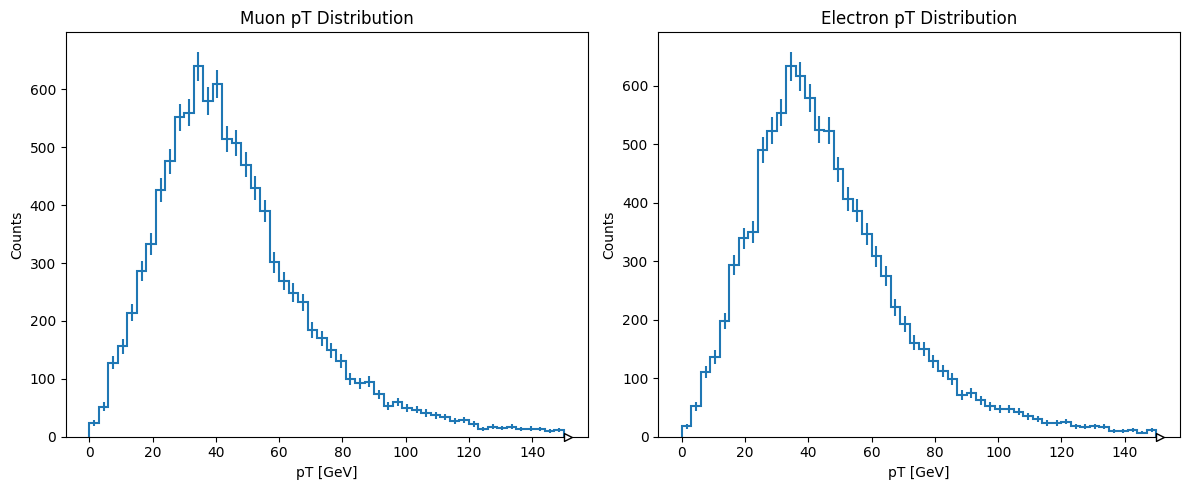

In [5]:
# Plot pT distributions using hist
h_mu_pt = hist.Hist.new.Regular(50, 0, 150, name="Muon pT [GeV]").Double()
h_mu_pt.fill(ak.flatten(muons.pt))
h_mu_pt.plot();

h_elec_pt = hist.Hist.new.Regular(50, 0, 150, name="Electron pT [GeV]").Double()
h_elec_pt.fill(ak.flatten(electrons.pt))
h_elec_pt.plot();  

#plot mupt and elecpt separately   
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
h_mu_pt.plot()
plt.title("Muon pT Distribution")
plt.xlabel("pT [GeV]")
plt.ylabel("Counts")
plt.subplot(1, 2, 2)
h_elec_pt.plot()
plt.title("Electron pT Distribution")
plt.xlabel("pT [GeV]")
plt.ylabel("Counts")
plt.tight_layout()
plt.show()

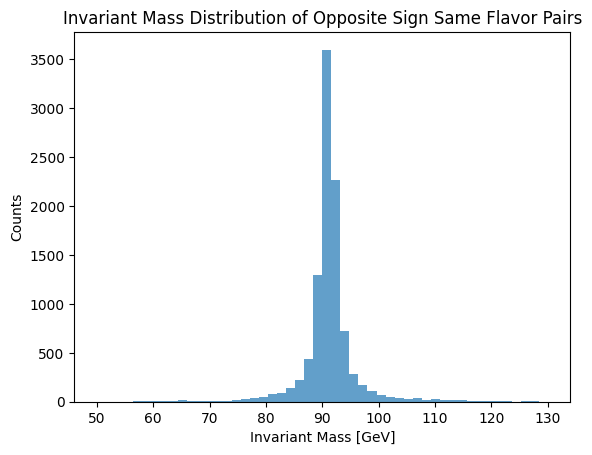

In [6]:
# opposite sign same flavor pairs
mu_pairs = ak.combinations(muons, 2, fields=["mu1", "mu2"])
os_sf_pairs = mu_pairs[(mu_pairs.mu1.charge + mu_pairs.mu2.charge) == 0]

ele_pairs = ak.combinations(electrons, 2, fields=["e1", "e2"])
os_sf_ele_pairs = ele_pairs[(ele_pairs.e1.charge + ele_pairs.e2.charge) == 0]

# invariant mass of pairs using vector addition
mu_mass = (mu_pairs.mu1 + mu_pairs.mu2).mass
ele_mass = (ele_pairs.e1 + ele_pairs.e2).mass

z_mass = ak.flatten(ak.concatenate([mu_mass, ele_mass], axis=1))

#plot invariant mass distribution
plt.hist(z_mass, bins=50, range=(50, 130), alpha=0.7)
plt.xlabel("Invariant Mass [GeV]")
plt.ylabel("Counts")
plt.title("Invariant Mass Distribution of Opposite Sign Same Flavor Pairs")
plt.show()

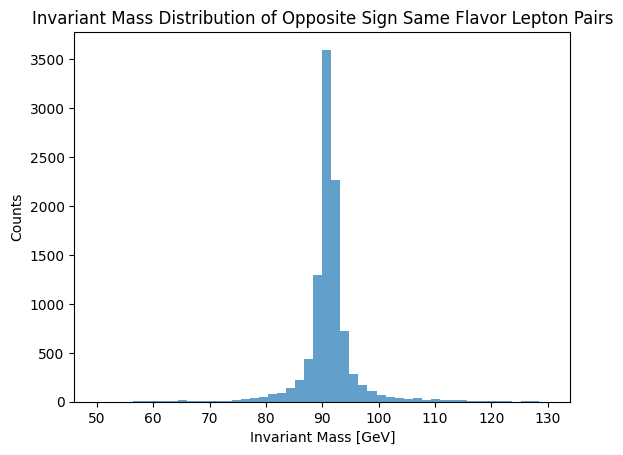

In [7]:
# Reconstruct Z boson candidates and plot their invariant mass distribution
leptons = ak.concatenate([muons, electrons], axis=1)
lepton_pairs = ak.combinations(leptons, 2, fields=["l1", "l2"])
os_sf_lepton_pairs = lepton_pairs[(lepton_pairs.l1.charge + lepton_pairs.l2.charge) == 0]
z_candidates = os_sf_lepton_pairs.l1 + os_sf_lepton_pairs.l2
z_candidate_masses = ak.flatten(z_candidates.mass)

plt.hist(z_candidate_masses, bins=50, range=(50, 130), alpha=0.7)
plt.xlabel("Invariant Mass [GeV]")
plt.ylabel("Counts")
plt.title("Invariant Mass Distribution of Opposite Sign Same Flavor Lepton Pairs")
plt.show()

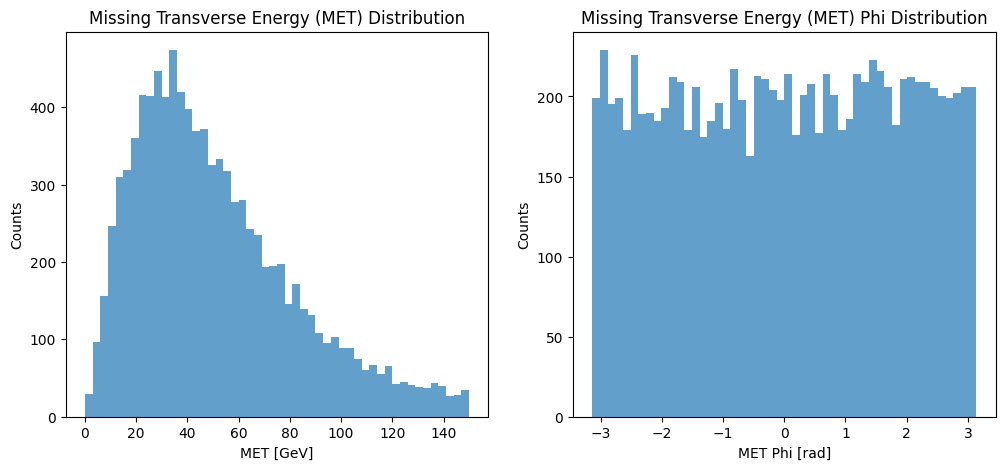

In [8]:
#extract MET information
met_pt = tree["MET_pt"].array(library="ak")
met_phi = tree["MET_phi"].array(library="ak")

#plot MET and phi distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(met_pt, bins=50, range=(0, 150), alpha=0.7)
plt.xlabel("MET [GeV]")
plt.ylabel("Counts")
plt.title("Missing Transverse Energy (MET) Distribution")

plt.subplot(1, 2, 2)
plt.hist(met_phi, bins=50, range=(-3.14, 3.14), alpha=0.7)
plt.xlabel("MET Phi [rad]")
plt.ylabel("Counts")
plt.title("Missing Transverse Energy (MET) Phi Distribution")
plt.show() 

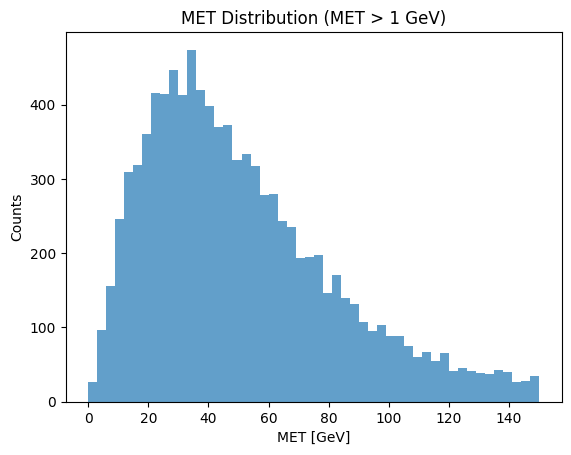

In [9]:
nonzero_met = met_pt[met_pt > 1]  # filter out near-zero MET
plt.hist(nonzero_met, bins=50, range=(0, 150), alpha=0.7)
plt.xlabel("MET [GeV]")
plt.ylabel("Counts")
plt.title("MET Distribution (MET > 1 GeV)")
plt.show()


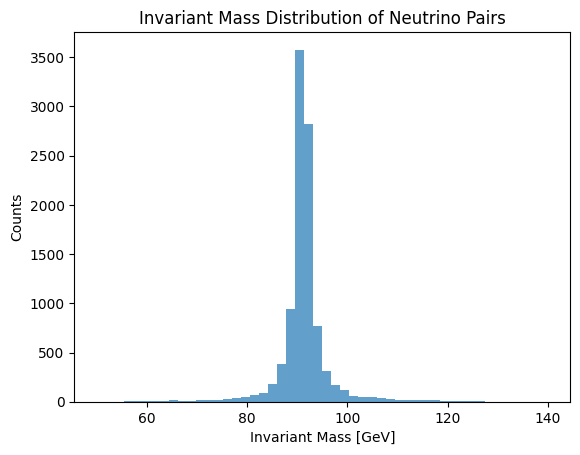

In [10]:
# reconstruct z from the neutrinos
neutrino = tree.arrays(["Neutrino_pt", "Neutrino_eta", "Neutrino_phi", "Neutrino_mass"])
neutrinos = ak.zip({
    "pt": neutrino.Neutrino_pt,
    "eta": neutrino.Neutrino_eta,
    "phi": neutrino.Neutrino_phi,
    "mass": neutrino.Neutrino_mass
}, with_name="Momentum4D")

z_nunu = ak.combinations(neutrinos, 2, fields=["nu1", "nu2"])
z_nu_candidates = z_nunu.nu1 + z_nunu.nu2
z_nu_masses = ak.flatten(z_nu_candidates.mass)

# plot the invariant mass distribution of neutrino pairs
plt.hist(z_nu_masses, bins=50, range=(50, 140), alpha=0.7)
plt.xlabel("Invariant Mass [GeV]")
plt.ylabel("Counts")
plt.title("Invariant Mass Distribution of Neutrino Pairs")
plt.show()


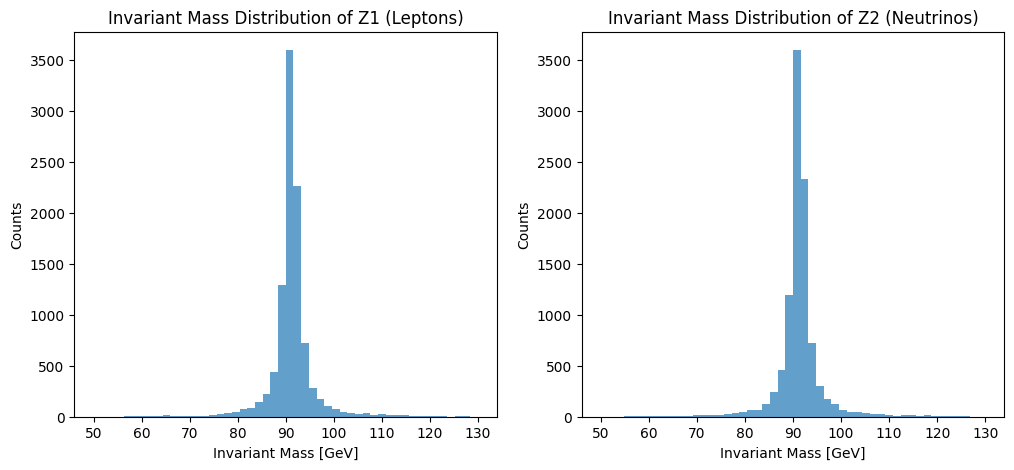

In [12]:
# z from leptons and neutrinos (use the combination arrays directly)

# use the full combination arrays (not indexing [0]) and build Z candidates by adding the two momenta
z1_candidates = lepton_pairs          # has fields l1, l2
z2_candidates = z_nunu                # has fields nu1, nu2

# compute invariant masses by adding the two momentum objects and taking .mass
z1_masses = ak.flatten((z1_candidates.l1 + z1_candidates.l2).mass)
z2_masses = ak.flatten((z2_candidates.nu1 + z2_candidates.nu2).mass)

# z invariant mass distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(z1_masses, bins=50, range=(50, 130), alpha=0.7)
plt.xlabel("Invariant Mass [GeV]")
plt.ylabel("Counts")
plt.title("Invariant Mass Distribution of Z1 (Leptons)")

plt.subplot(1, 2, 2)
plt.hist(z2_masses, bins=50, range=(50, 130), alpha=0.7)
plt.xlabel("Invariant Mass [GeV]")
plt.ylabel("Counts")
plt.title("Invariant Mass Distribution of Z2 (Neutrinos)")
plt.show()

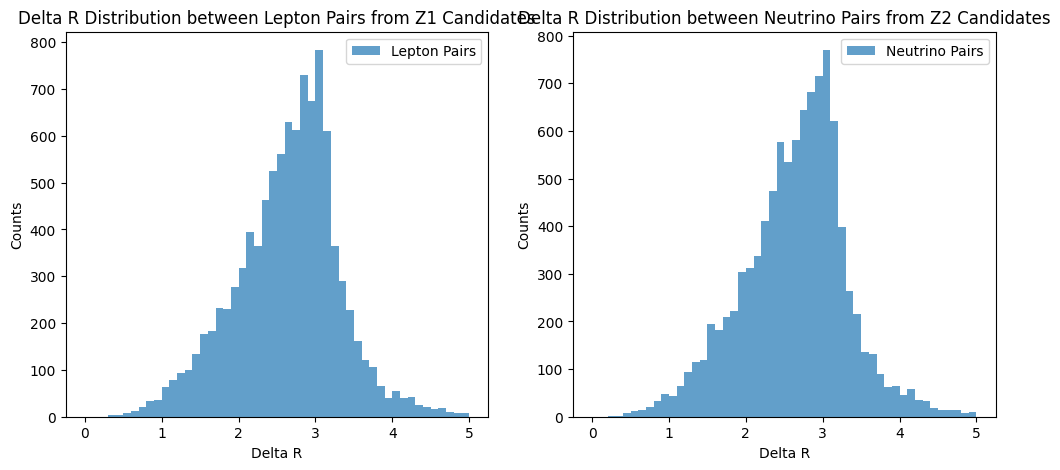

In [18]:
#compute delta R between lepton pairs from Z1 candidates
deta = z1_candidates.l1.eta - z1_candidates.l2.eta
dphi = z1_candidates.l1.phi - z1_candidates.l2.phi
dphi = (dphi + np.pi) % (2 * np.pi) - np.pi  # wrap to [-pi, pi]
delta_r = np.sqrt(deta**2 + dphi**2)

#compute delta R between neutrino pairs from Z2 candidates
deta_nu = z2_candidates.nu1.eta - z2_candidates.nu2.eta
dphi_nu = z2_candidates.nu1.phi - z2_candidates.nu2.phi
dphi_nu = (dphi_nu + np.pi) % (2 * np.pi) - np.pi  # wrap to [-pi, pi]
delta_r_nu = np.sqrt(deta_nu**2 + dphi_nu**2)

#plot delta R distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(delta_r, bins=50, range=(0, 5), alpha=0.7)
plt.xlabel("Delta R")
plt.ylabel("Counts")
plt.title("Delta R Distribution between Lepton Pairs from Z1 Candidates")
plt.legend(["Lepton Pairs"])

plt.subplot(1, 2, 2)
plt.hist(delta_r_nu, bins=50, range=(0, 5), alpha=0.7)
plt.xlabel("Delta R")
plt.ylabel("Counts")
plt.title("Delta R Distribution between Neutrino Pairs from Z2 Candidates")
plt.legend(["Neutrino Pairs"])
plt.show()

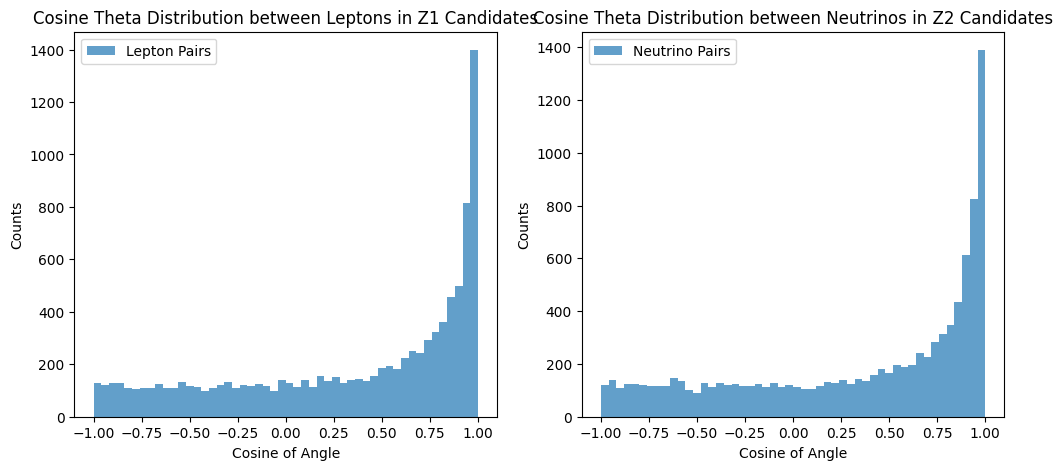

In [19]:
#compute cosine of angle between leptons in Z1 candidates
dot_product = (z1_candidates.l1.px * z1_candidates.l2.px +
               z1_candidates.l1.py * z1_candidates.l2.py +
               z1_candidates.l1.pz * z1_candidates.l2.pz)
magnitude_l1 = np.sqrt(z1_candidates.l1.px**2 + z1_candidates.l1.py**2 + z1_candidates.l1.pz**2)
magnitude_l2 = np.sqrt(z1_candidates.l2.px**2 + z1_candidates.l2.py**2 + z1_candidates.l2.pz**2)
cos_theta = dot_product / (magnitude_l1 * magnitude_l2)

#cosine between neutrinos in Z2 candidates
dot_product_nu = (z2_candidates.nu1.px * z2_candidates.nu2.px +
                  z2_candidates.nu1.py * z2_candidates.nu2.py +
                  z2_candidates.nu1.pz * z2_candidates.nu2.pz)
magnitude_nu1 = np.sqrt(z2_candidates.nu1.px**2 + z2_candidates.nu1.py**2 + z2_candidates.nu1.pz**2)
magnitude_nu2 = np.sqrt(z2_candidates.nu2.px**2 + z2_candidates.nu2.py**2 + z2_candidates.nu2.pz**2)
cos_theta_nu = dot_product_nu / (magnitude_nu1 * magnitude_nu2)

#plot cosine theta distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(cos_theta, bins=50, range=(-1, 1), alpha=0.7)
plt.xlabel("Cosine of Angle")
plt.ylabel("Counts")
plt.title("Cosine Theta Distribution between Leptons in Z1 Candidates")
plt.legend(["Lepton Pairs"])

plt.subplot(1, 2, 2)
plt.hist(cos_theta_nu, bins=50, range=(-1, 1), alpha=0.7)
plt.xlabel("Cosine of Angle")
plt.ylabel("Counts")
plt.title("Cosine Theta Distribution between Neutrinos in Z2 Candidates")
plt.legend(["Neutrino Pairs"])
plt.show()

In [22]:
#estimate cross-section from number of events and luminosity
num_events = tree.num_entries
gen_pb = 0.2508 +- 0.0006425 #MadGraph's reported cross-section for pp->ZZ->2l & 2v at 13 TeV
luminosity = num_events / gen_pb  # in pb^-1

print(f"Estimated Luminosity: {luminosity:.2f} pb^-1")

#z z selection efficiency
z1_in_window = (z1_masses > 60) & (z1_masses < 120)
z2_in_window = (z2_masses > 60) & (z2_masses < 120)
both_in_window = z1_in_window & z2_in_window
efficiency = ak.sum(both_in_window) / num_events
print(f"ZZ Selection Efficiency: {efficiency:.4f}")

#print number of events passing selection
num_passing = ak.sum(both_in_window)
print(f"Number of events passing ZZ selection: {num_passing}")

#final estimated cross-section after selection
final_cross_section = gen_pb * efficiency
print(f"Estimated Cross-Section after ZZ Selection: {final_cross_section:.4f} pb")


Estimated Luminosity: 39974.82 pb^-1
ZZ Selection Efficiency: 0.9921
Number of events passing ZZ selection: 9921
Estimated Cross-Section after ZZ Selection: 0.2482 pb
